# Canonical Noise Mechanism

The canonical noise mechanism ([see AV23](https://projecteuclid.org/journals/annals-of-statistics/volume-51/issue-2/Canonical-noise-distributions-and-private-hypothesis-tests/10.1214/23-AOS2259.short)) can privatize any float-valued statistic with finite sensitivity.

Under $(\epsilon, \delta)$-DP,
the canonical noise distribution follows the Tulap distribution,
which is a combination of discrete laplace noise and continuous uniform noise.

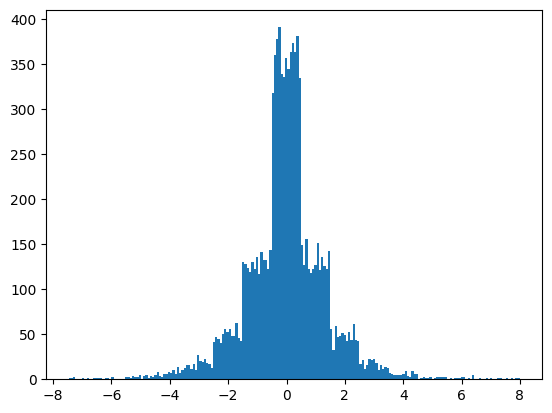

In [1]:
import matplotlib.pyplot as plt
import opendp.prelude as dp
dp.enable_features("contrib")

space = dp.atom_domain(T=float, nan=False), dp.absolute_distance(T=float)
# calibrate noise to satisfy (1.0, 1e-7)-approxDP when sensitivity is 1.0
m_cnd = space >> dp.m.then_canonical_noise(d_in=1.0, d_out=(1.0, 1e-7))

# plot 10k samples
plt.hist([m_cnd(0.) for _ in range(10_000)], bins=200);

We also have a suite of inference tools that can be applied under the assumption that your statistic is binomially distributed.
An example of binomially-distributed data can be found when counting the number of married individuals in the California demographics dataset,
a microdata-level dataset with attributes for age, sex, education, race, income and marriage status.

In [2]:
import opendp.prelude as dp
import polars as pl

dp.enable_features("contrib")
columns = "age", "sex", "educ", "race", "income", "married"
married_data = list(pl.read_csv(
    dp.examples.get_california_pums_path(), 
    has_header=False, 
    new_columns=columns,
    ignore_errors=True,
)["married"])

context = dp.Context.compositor(
    data=married_data,
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=0.2, delta=1e-8),
    split_evenly_over=2
)

We'll use the canonical noise mechanism to conduct statistical inference on the 'married' column,
where values are either 0 or 1, indicating marriage status.

The following query counts the number of married individuals in the dataset.

In [3]:
query = context.query().cast_default(float).impute_constant(0.0).clamp((0.0, 1.0)).sum()

The canonical noise mechanism behaves similarly to the Laplace or Gaussian mechanism in that it is an additive noise mechanism.

The implementation of the canonical noise mechanism in OpenDP only supports scalar-valued float inputs and can only be calibrated to satisfy $(\epsilon, \delta)$-DP.

In [4]:
estimate: float = query.canonical_noise().release()
estimate

543.5862745175556

## Binomial Assumption

If you expect that the statistic you are privatizing follows a binomial distribution,
which is commonly the case in counting queries,
there is a suite of tools for conducting hypothesis tests and constructing confidence intervals.

These utilities can be used standalone via the [BinomialCND](../../python/opendp.extras.numpy.canonical.rst#opendp.extras.numpy.canonical.BinomialCND) class,
or you can simply provide a `binomial_size` prior before making the release and OpenDP will instantiate the class for you.

In [5]:
from opendp.extras.numpy.canonical import BinomialCND

estimate: BinomialCND = query.canonical_noise(binomial_size=1_000).release()
estimate

BinomialCND(estimate=502.87558450908193, d_in=1.0000000093132269, d_out=(0.1, 5e-09), size=1000)

The `binomial_size` argument is a prior about the number of bernoulli draws- typically the number of records in the dataset.

Let's get familiar with each of the inference tools.

### Confidence Intervals

In [6]:
ci = estimate.confidence_interval(alpha=.05)
ci

(0.4608320830961166, 0.5449190859220473)

With a statistical significance of .05 (with 95% confidence), the true proportion of married individuals is within the interval ``ci``.

In [7]:
lower_ci = estimate.confidence_interval(alpha=.05, side='lower')
lower_ci

0.46834281999150473

With a statistical significance of .05 (with 95% confidence), the true proportion of married individuals is no less than ``lower_ci``.

### P-Values

Consider a statistical test where the null hypothesis states that the probability of a success (incrementing the counter) is `theta`.
The p-value tells you the probability of observing `estimate` under the assumption that the null hypothesis is true.
A very small p-value (less than some statistical significance level) indicates that the null hypothesis should be rejected.

For examples in this document, we'll start with a prior assumption that the probability of a person being married is 0.5.

In [8]:
theta = 0.5

Now, test the null hypothesis that the probability of a person being married is 0.5:

In [9]:
p_value_married = estimate.p_value(theta=theta)
p_value_married

0.8861710889637788

Under this null hypothesis, the probability of observing `estimate` is low:
this tells us that if the true marriage rate was actually 0.5, then it would be unlikely we would have observed such a high private estimate.

You can also test the null hypothesis that the probability of a person being married is no less than 0.5:

In [10]:
p_value_married = estimate.p_value(theta=theta, tail='left')
p_value_married

0.5569144555181105

Under this hypothesis, it's highly likely to observe an outcome like `estimate`, because the private estimate corroborates the null hypothesis.

When the null hypothesis is that the probability of a person being married is no greater than 0.5, the test more strongly indicates that the outcome is unlikely:

In [11]:
p_value_married = estimate.p_value(theta=theta, tail='right')
p_value_married

0.4430855444818895

As you can see, the one-sided test is stronger than the two-sided test, which is reflected in the p-value.

### Uniformly-Most-Powerful Tests
`one_sided_uniformly_most_powerful_tests` shows how p-values vary over all potential estimates between 0 and the dataset size.

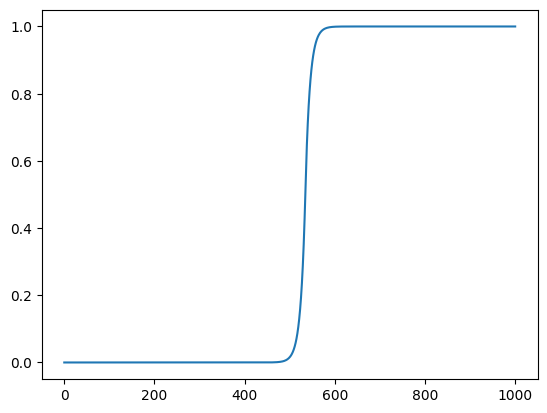

In [12]:
from opendp.extras.numpy.canonical import one_sided_uniformly_most_powerful_tests

ump_tests = one_sided_uniformly_most_powerful_tests(
    d_in=estimate.d_in, d_out=estimate.d_out, size=1_000, theta=theta, alpha=0.05, tail="left"
)

import matplotlib.pyplot as plt

plt.plot(list(range(0, 1001)), ump_tests);

This visual shows how, when the null hypothesis is that the population rate is no smaller than 0.5, the probability of observing an outcome at least as extreme as theta approaches one.